<h1>Load data</h1>

In [218]:
import pandas as pd
#Data from here: https://www.kaggle.com/datasets/pqbsbk/german-news-dataset
news_data = pd.read_csv('data.csv')

In [363]:
news_data = news_data.dropna()
#Load the text from the first k articles
k = 1000
text = news_data.iloc[:k].text.values

<h1>Word level text analysis with spaCy</h1>

In [364]:
#Create CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
#Set the stop_words parameter to filter out words like 'the','of','is',etc.
german_stop_words = stopwords.words('german')
vectorizer = CountVectorizer(stop_words=german_stop_words)

In [367]:
#Make bag of words

#Regex expressions and functions for cleaning out words
import re

def has_numbers(inputString):
    return bool(re.search(r'\d', inputString))

def good_word(word):
    if len(word) >= 3 and not has_numbers(word):
        return True
    return False

sum_words = bag_of_words.sum(axis=0)
words_freq = [(word,sum_words[0,idx]) for word,idx in vectorizer.vocabulary_.items() if good_word(word)]
words_freq = sorted(words_freq,key=lambda x:x[1],reverse=True)
top_words = [tup[0] for tup in words_freq]
words_dict = dict(words_freq)

In [412]:
k = 25
print('Top {} words are:'.format(k))
for i in range(k):
    print('{}. {} - {} times'.format(i+1,words_freq[i][0],words_freq[i][1]))

Top 25 words are:
1. anzeige - 3249 times
2. lesen - 1693 times
3. mehr - 1639 times
4. corona - 1421 times
5. menschen - 1194 times
6. sei - 1182 times
7. wurde - 1142 times
8. welt - 1077 times
9. sagte - 1042 times
10. trump - 967 times
11. seit - 930 times
12. quelle - 848 times
13. deutschland - 844 times
14. prozent - 832 times
15. gibt - 812 times
16. schon - 779 times
17. immer - 747 times
18. worden - 696 times
19. millionen - 694 times
20. zwei - 680 times
21. euro - 674 times
22. jahren - 668 times
23. inhalte - 649 times
24. finden - 644 times
25. zahl - 630 times


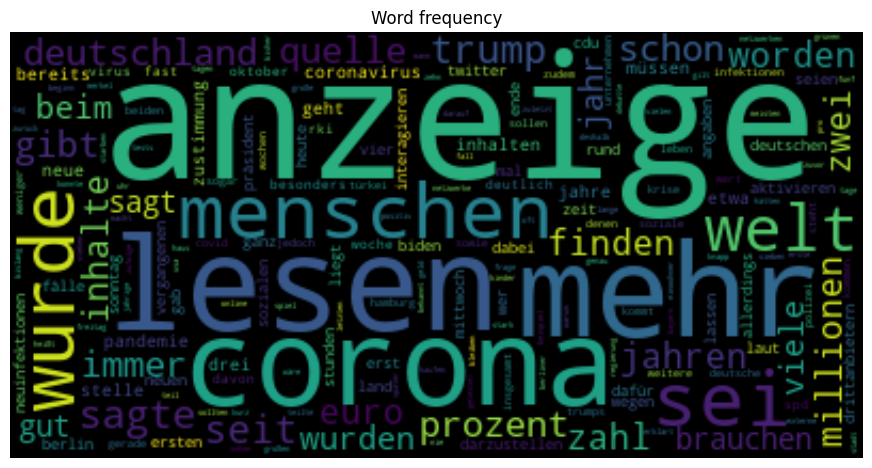

In [370]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=words_dict)
plt.figure(figsize=(11,9),facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word frequency")
plt.show()

<h2>NLTK and spaCy for lemmatization</h2>

<p>Use NLTK to split the corpus up into sentences which we then feed to spaCy in order to determine the POS and get better lemmatization results. The goal of lemmatization is breaking down the number of used words even further by not including all the conjugations</p>

In [427]:
from nltk.tokenize import sent_tokenize

#Get all sentences from text
combined_text = '\n'.join(text)
sents = sent_tokenize(combined_text,language='german')
#Make all sentences lower case
sents = [sent.lower().replace('\n',' ') for sent in sents]

In [440]:
from tqdm.notebook import tqdm
import spacy

nlp = spacy.load('de_core_news_sm')

def good_lemma(word):
    if word.is_alpha and word.pos_ != "PROPN":
        return True
    return False

#For every sentence, lemmatize it and get the POS for each token and make a tuple along with the original token
nlp_sents = [[(word,word.lemma_,word.pos_) for word in nlp(sent) if good_lemma(word)] for sent in tqdm(sents)]

  0%|          | 0/35761 [00:00<?, ?it/s]

In [441]:
#Space seperate all the lemmatized tokens
lemma_sents = [' '.join([tup[1] for tup in sent]) for sent in nlp_sents]

In [442]:
bag_of_words = vectorizer.fit_transform(lemma_sents)

In [443]:
#Make bag of words
sum_words = bag_of_words.sum(axis=0)
lemma_words_freq = [(word,sum_words[0,idx]) for word,idx in vectorizer.vocabulary_.items() if good_word(word)]
lemma_words_freq = sorted(lemma_words_freq,key=lambda x:x[1],reverse=True)
lemma_top_words = [tup[0] for tup in lemma_words_freq]
lemma_words_dict = dict(lemma_words_freq)

In [446]:
k = 10
print('Top {} words are:'.format(k))
for i in range(k):
    print('{}. {} - {} times'.format(i+1,lemma_words_freq[i][0],lemma_words_freq[i][1]))

Top 10 words are:
1. anzeigen - 3272 times
2. sagen - 1896 times
3. lesen - 1729 times
4. mehr - 1639 times
5. geben - 1612 times
6. gut - 1240 times
7. menschen - 1189 times
8. weit - 1081 times
9. groß - 1041 times
10. kommen - 1024 times


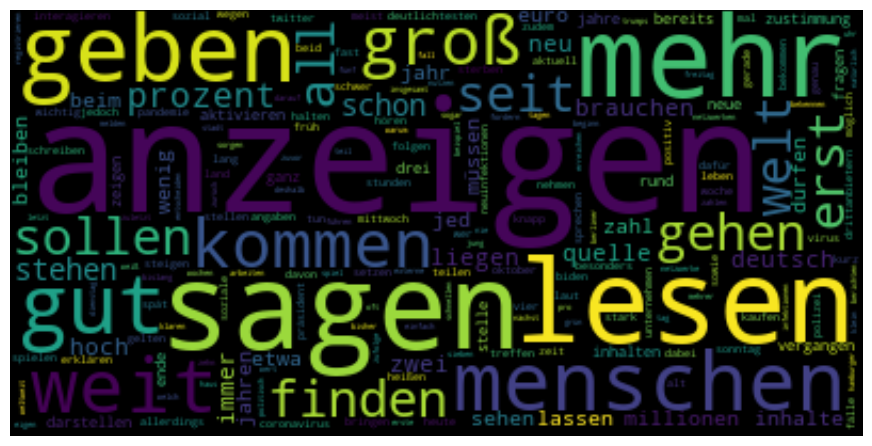

In [447]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=lemma_words_dict)
plt.figure(figsize=(11,9),facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [456]:
#Generate data for plot

lemma_words_counts = [word[1] for word in lemma_words_freq]
total_lemma_words = sum(lemma_words_counts)

normal_words_counts = [word[1] for word in words_freq]
total_words = sum(normal_words_counts)

x = np.arange(0,12000)
lemma_y = [100*round(sum(lemma_words_counts[:i])/total_lemma_words,3) for i in x]
word_y = [100*round(sum(normal_words_counts[:i])/total_words,3) for i in x]

In [459]:
import numpy as np
import matplotlib.pyplot as plt
with plt.style.context('bmh'):
    plt.plot(x,lemma_y,color='blue',label='Lemma')
    plt.plot(x,word_y,color='red',label='Word')
    plt.title("Corpus percentage vs. words known")
    plt.xlabel("Known words")
    plt.ylabel("Percentage of corpus")
    plt.legend(loc='best')
    #plt.show()
    plt.savefig('lemma_word_log_plot.png')
    #plt.show()

<h2>Study POS tags</h2>

In [392]:
def add_if_key_not_exist(dict_obj, key):
    """ Add new key-value pair to dictionary only if
    key does not exist in dictionary. """
    if key not in dict_obj:
        dict_obj.update({key: 1})
    else:
        dict_obj[key] += 1
        
pos_count_dic = {}
for sent in nlp_sents:
    for tup in sent:
        pos = tup[2]
        if pos not in pos_count_dic:
            #Add lemma with a count of 1 to dictionary of POS tag/word counts for the current POS
            pos_count_dic[pos] = {tup[1]:1}
        else:
            add_if_key_not_exist(pos_count_dic[pos],tup[1])

In [393]:
#Turn into a pandas dataframe by adding a pos column
pos_frame = pd.DataFrame()
for pos in pos_count_dic.keys():
    new_frame = pd.DataFrame.from_dict(pos_count_dic[pos],orient='index',columns=['num'])
    new_frame['pos'] = pos
    pos_frame = pos_frame.append(new_frame)

In [394]:
#Get number of times each POS occurred
pos_counts = pos_frame.groupby('pos').num.sum().sort_values(ascending=False)

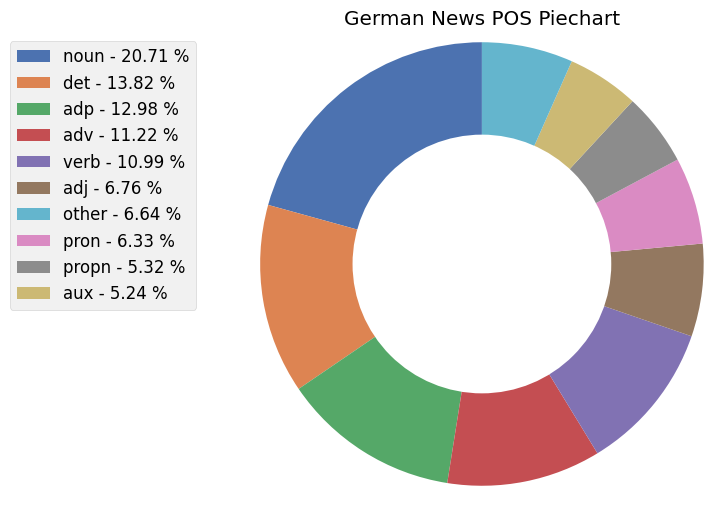

In [466]:
#Plot a pie chart with 
n = 9
data = list(pos_counts.values[:n]) + [sum(pos_counts.values[n:])]
labels = list(pos_counts.index)[:n]
labels = [val.lower() for val in labels] + ['other']

with plt.style.context('bmh'):
    colors = sns.color_palette('deep')
    plt.figure(figsize=(10,6))
    percent = 100*(data/sum(data))
    patches, texts = plt.pie(data, colors=colors, startangle=90, radius=1.2)
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, percent)]
    sort_legend = True
    if sort_legend:
        patches, labels, dummy =  zip(*sorted(zip(patches, labels, data),
                                              key=lambda x: x[2],
                                              reverse=True))

    plt.legend(patches, labels, loc='best', bbox_to_anchor=(-0.1, 1.),
               fontsize=12)
    plt.title('German News POS Piechart')
    plt.show()
    plt.tight_layout()


In [405]:
x_range = 5000

def get_pos_percentage(freqs,x_range):
    """
    Return a list of percentages representing how each number of known words account for out of all
    the words in the count_list.
    """
    total_words = sum(freqs)
    x = np.arange(0,x_range)
    vals = [100*round(sum(freqs[:i])/total_words,3) for i in x]
    return vals

pos_tags = ['NOUN','ADV','VERB','ADJ']
pos_vals = []
for tag in pos_tags:
    freqs = pos_frame[pos_frame.pos == tag]['num'].sort_values(ascending=False).values
    pos_val = get_pos_percentage(freqs,x_range)
    pos_vals.append(pos_val)

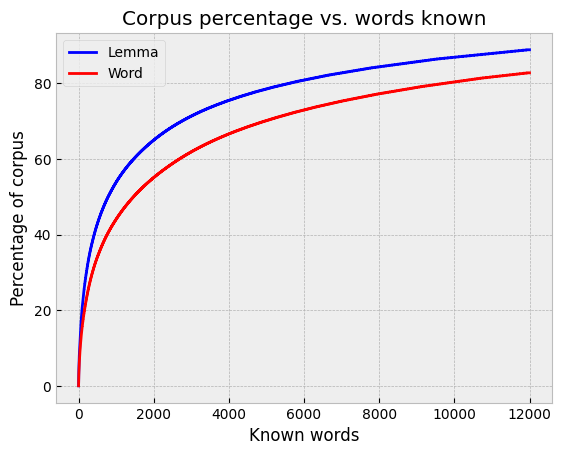

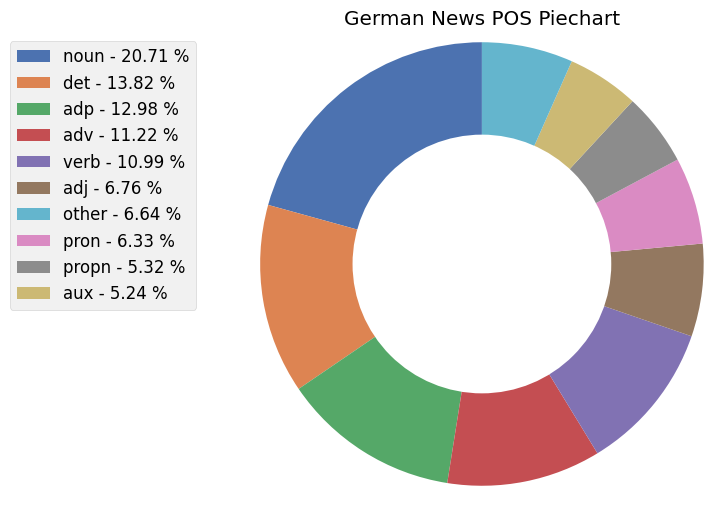

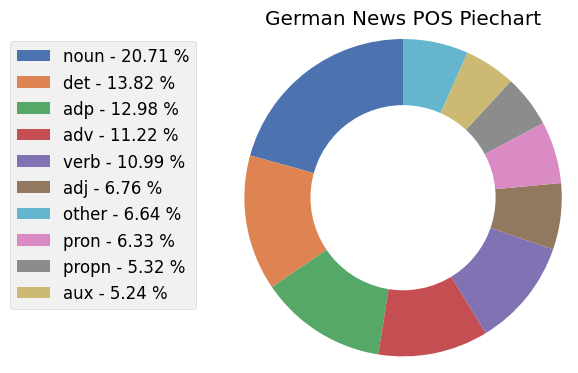

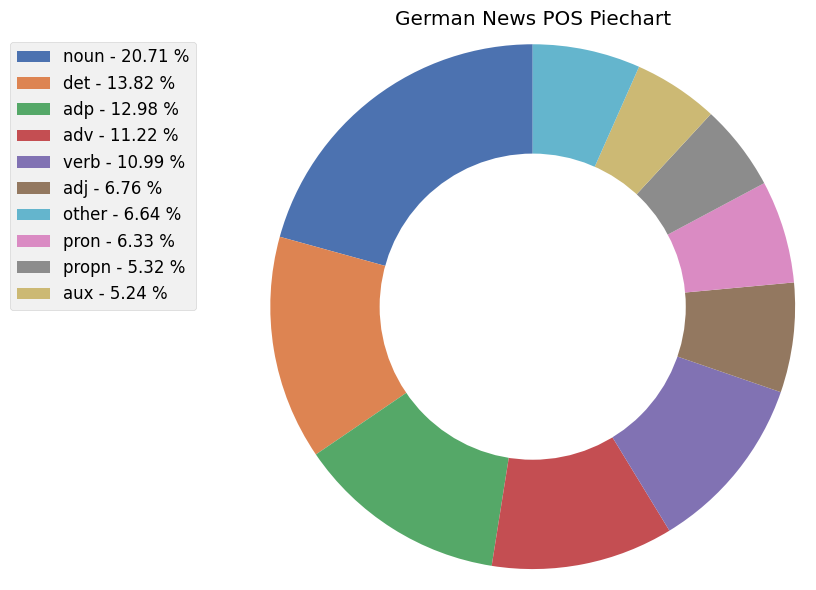

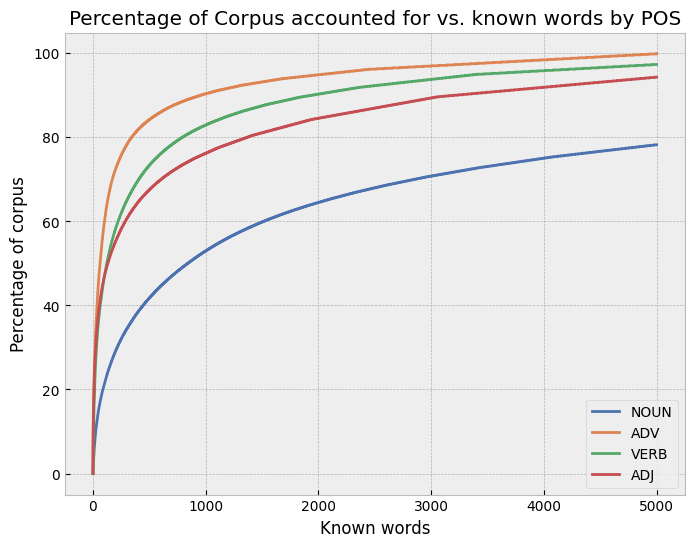

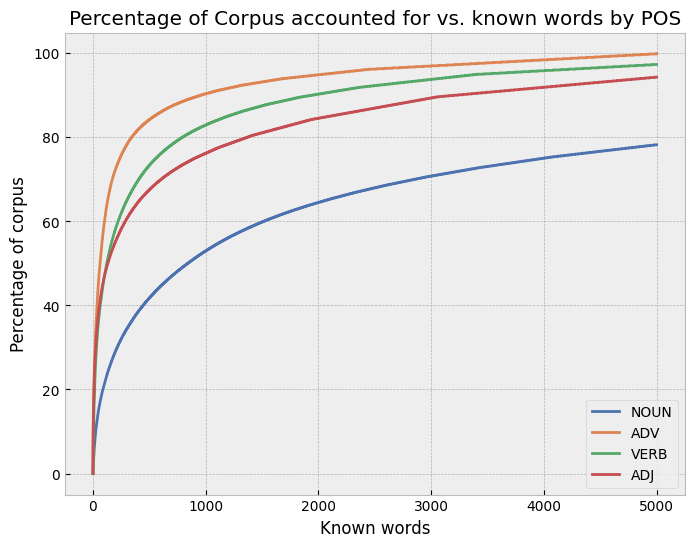

In [465]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

x = np.arange(0,x_range)
with plt.style.context('bmh'):
    plt.figure(figsize=(8,6))
    #colors = ['red','green','blue','orange']
    #colors = ['#a6cee3','#33a02c','#fb9a99','#e31a1c']
    colors = sns.color_palette('deep')
    for i,tag in enumerate(pos_tags[:5]):
        plt.plot(x,pos_vals[i],color=colors[i],label=tag)
    plt.title("Percentage of Corpus accounted for vs. known words by POS")
    plt.xlabel("Known words")
    plt.ylabel("Percentage of corpus")
    plt.legend(loc='best')
    plt.show()
